In [1]:
DATA_CSV = "../results/basin_fractions.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
MAIN_FIGURE_ID = "7"
SUP_FIGURE_ID = "s5"
METRICS = ["rmsd", "kld"]
METHODS = None # plot all methods
LIM = {"kld": (0, 1.5)}
FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

import sdmarkov.plotting.config as pc
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_kld
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.basins import get_convergence_matrix, get_basin_fractions
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.analysis.utils import load_or_generate_data, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

## Data generation or loading

In [3]:
def get_data_basin_fractions(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):
    """
    Compute basin fraction comparison metrics (RMSD, KLD) for SD, null,
    uniform, and random groupings of a Boolean network.

    Returns a long-format DataFrame with one row per method per run.
    """
    rows = []

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    # Full transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # Grouped transition matrices
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    if n_attractors < 2:
        return pd.DataFrame(rows)

    # Actual convergence and basin fractions
    T_inf = nsquare(T, NSQUARE_STEPS, DEBUG=DEBUG)
    convergence = get_convergence_matrix(T_inf, predicted_attractor_indices, DEBUG=DEBUG)
    basin_fractions = get_basin_fractions(convergence, DEBUG=DEBUG)

    # Reference
    ref_basin_fractions = get_uniform_matrix(1, n_attractors)

    # grouped basin fractions
    def grouped_basin(T_grouped, indices, predicted_attractors, DEBUG=False):
        T_grouped_inf = nsquare(T_grouped, NSQUARE_STEPS, DEBUG=DEBUG)
        T_grouped_inf_expanded = expand_matrix(T_grouped_inf, indices, DEBUG=DEBUG)
        convergence_matrix = get_convergence_matrix(T_grouped_inf_expanded,predicted_attractors,DEBUG=DEBUG)
        return get_basin_fractions(convergence_matrix, DEBUG=DEBUG)

    sd_basin_fractions = grouped_basin(Tsd, sd_indices, predicted_attractor_indices, DEBUG=DEBUG)
    null_basin_fractions = grouped_basin(Tnull, null_indices, predicted_attractor_indices, DEBUG=DEBUG)

    # Find rmsd, kld and add to rows
    def add_row(method, predictions, run=None):
        rmsd_val = get_rms_diff(basin_fractions, predictions, partial=True, DEBUG=DEBUG)
        kld_val = get_kld(basin_fractions, predictions, partial=True, DEBUG=DEBUG)
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "rmsd": rmsd_val,
            "kld": kld_val,
            "n_states": n_states,
            "n_attractors": n_attractors,
        })

    # Deterministic / reference methods
    add_row("sd_mc", sd_basin_fractions)
    add_row("null_mc", null_basin_fractions)
    add_row("ref", ref_basin_fractions)

    # Random runs
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        random_basin_fractions = grouped_basin(Trandom, random_indices, predicted_attractor_indices, DEBUG=DEBUG)
        add_row("random_mc", random_basin_fractions, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_basin_fractions,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/basin_fractions.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,rmsd,kld,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.015687,0.000739,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,0.299199,0.191636,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0.299199,0.191636,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,0.296405,0.188307,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,0.303454,0.196765,1024,2,asynchronous



DataFrame shape: (1518, 8)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


## Data analysis

In [6]:
# filter out networks with a single attractor
df_multi = df[df["n_attractors"] > 1].copy()

print("Dataframe filtered to networks with multiple attractors")
print("DataFrame shape:", df_multi.shape)
print("Methods present:", df_multi.method.unique())
print("Number of unique networks:", df_multi.bnet.nunique())

display(df_multi.head())

Dataframe filtered to networks with multiple attractors
DataFrame shape: (1518, 8)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


,bnet,method,run,rmsd,kld,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.015687,0.000739,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,0.299199,0.191636,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0.299199,0.191636,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,0.296405,0.188307,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,0.303454,0.196765,1024,2,asynchronous


In [7]:
df_metrics = network_level_metrics_df(df=df_multi)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["rmsd", "kld"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,rmsd,kld,n_states,n_attractors,update_scheme
0,n010_000.bnet,null_mc,0.299199,0.191636,1024.0,2.0,asynchronous
1,n010_000.bnet,random_mc,0.299086,0.191515,1024.0,2.0,asynchronous
2,n010_000.bnet,ref,0.299199,0.191636,1024.0,2.0,asynchronous
3,n010_000.bnet,sd_mc,0.015687,0.000739,1024.0,2.0,asynchronous
4,n010_001.bnet,null_mc,0.079382,0.067733,64.0,5.0,asynchronous



DataFrame shape: (184, 7)
Methods present: ['null_mc' 'random_mc' 'ref' 'sd_mc']
Number of unique networks: 46

Network-level classification metrics:


rmsd                                kld                 \
               mean  min    median       max      mean  min    median   
method                                                                  
null_mc    0.128512  0.0  0.103435  0.597704  0.128508  0.0  0.037665   
random_mc  0.129202  0.0  0.102729  0.597540  0.128456  0.0  0.039184   
ref        0.117606  0.0  0.115783  0.412889  0.089343  0.0  0.057107   
sd_mc      0.053851  0.0  0.028407  0.369878  0.034871  0.0  0.003177   

                     
                max  
method               
null_mc    1.099594  
random_mc  1.098312  
ref        0.475987  
sd_mc      0.321700

## Plotting

In [8]:
pc.apply_style()

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PosixPath('../results/figures/Figure_7_Basin_fractions.png')

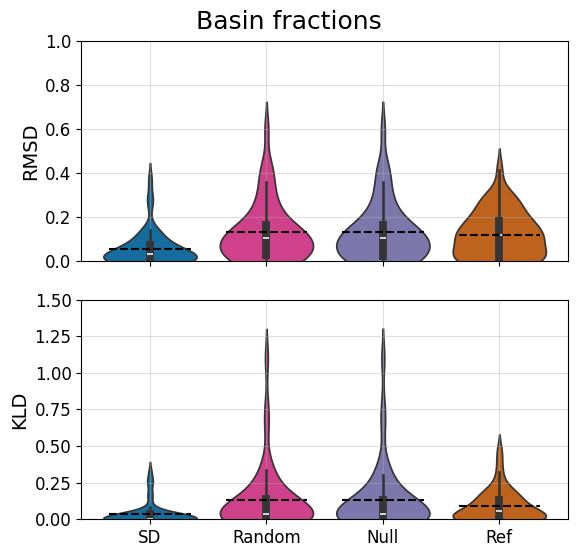

In [9]:
fig1 = plot_violin_figure(df_metrics, metrics=METRICS, figure_id=MAIN_FIGURE_ID, lim=LIM)

save_figure(fig1, figure_id=MAIN_FIGURE_ID, outdir=FIGURE_DIR)

PosixPath('../results/figures/Figure_s5_Basin_fractions.png')

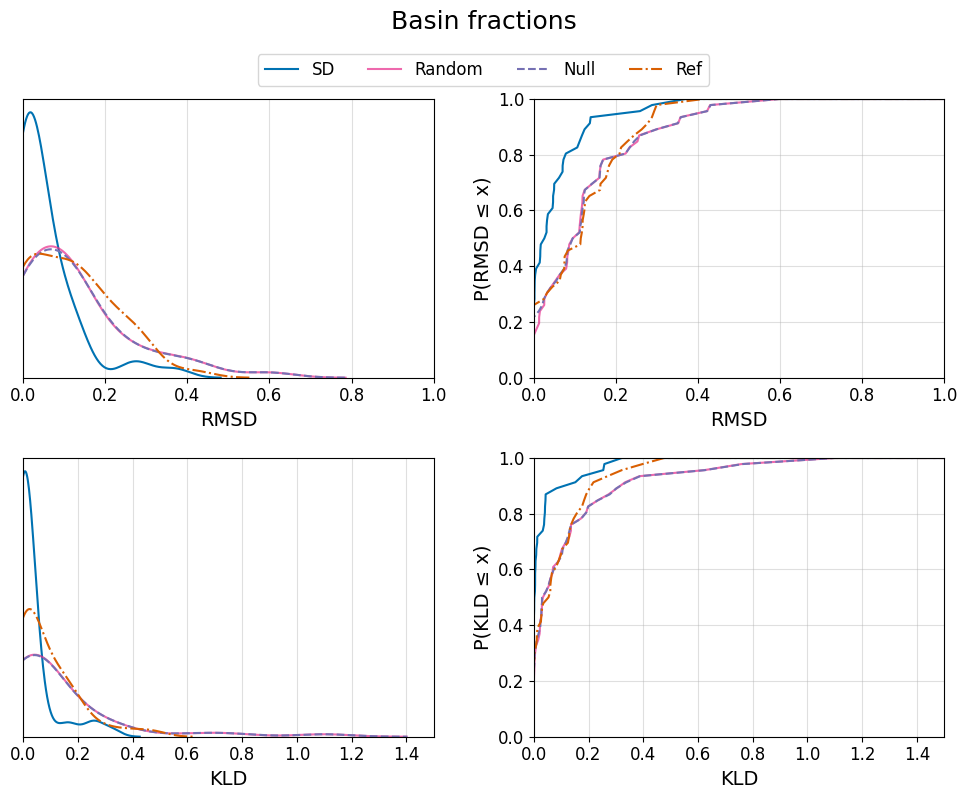

In [10]:
fig2 = plot_distribution_figure(df_metrics, metrics=METRICS, figure_id=SUP_FIGURE_ID, lim=LIM)

save_figure(fig2, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)